# Домашняя работа 8. Прогнозирование методами машинного обучения

Лазарев Эдуард Артемович
N33471

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Загружаем данные
df = pd.read_csv('wine_Austral2.dat', sep='\t')
len(df)

174

Проверяем правильность данных

In [3]:
df

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
0,2585,1954,85,464,112,1686,15136,1980,1,JAN 1980
1,3368,2302,89,675,118,1591,16733,1980,2,FEB 1980
2,3210,3054,109,703,129,2304,20016,1980,3,MAR 1980
3,3111,2414,95,887,99,1712,17708,1980,4,APR 1980
4,3756,2226,91,1139,116,1471,18019,1980,5,MAY 1980
...,...,...,...,...,...,...,...,...,...,...
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994


In [4]:
df.dtypes

fort       int64
dry        int64
sweet      int64
red        int64
rose       int64
spark      int64
total      int64
year_      int64
month_     int64
date_     object
dtype: object

Выбираем только один столбец с красным вином

In [5]:
df1 = df[ df.columns[3] ]
#проверка
df1.head(15)

0      464
1      675
2      703
3      887
4     1139
5     1077
6     1318
7     1260
8     1120
9      963
10     996
11     960
12     530
13     883
14     894
Name: red, dtype: int64

Построим графики и определим,тип тренда (линейный или нет) и тип сезонности ( аддитивный или мультипликативный)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


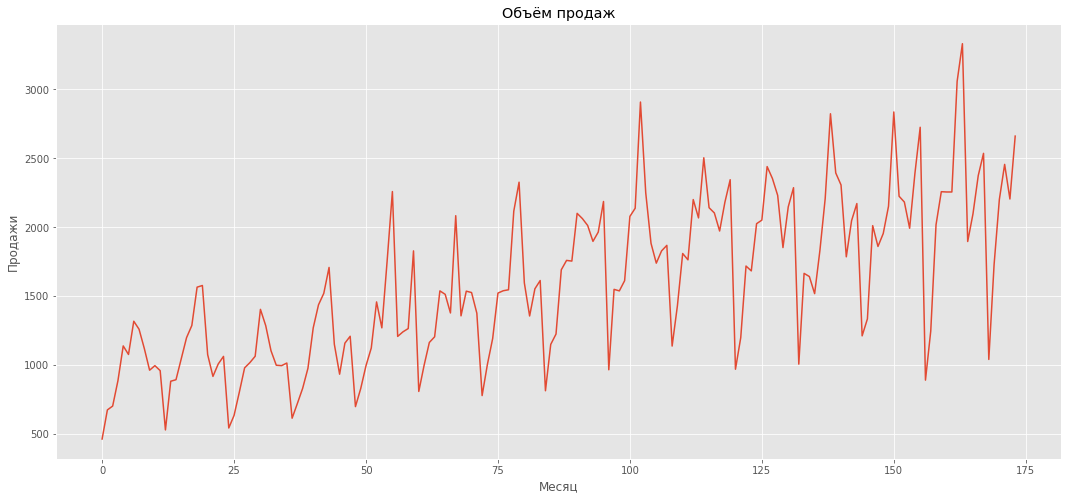

In [6]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from statsmodels.tsa.api import ExponentialSmoothing
plt.figure(figsize=(18, 8))
df1.plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'Объём продаж')
plt.show()

По этому графику можно определить, что тренд линейный, а сезонность мультипликативная. Можно проверить сезонность, взяв логарифм от функции. Если сезонные отклонения будут одинаковыми, то это докажет мультипликативность.

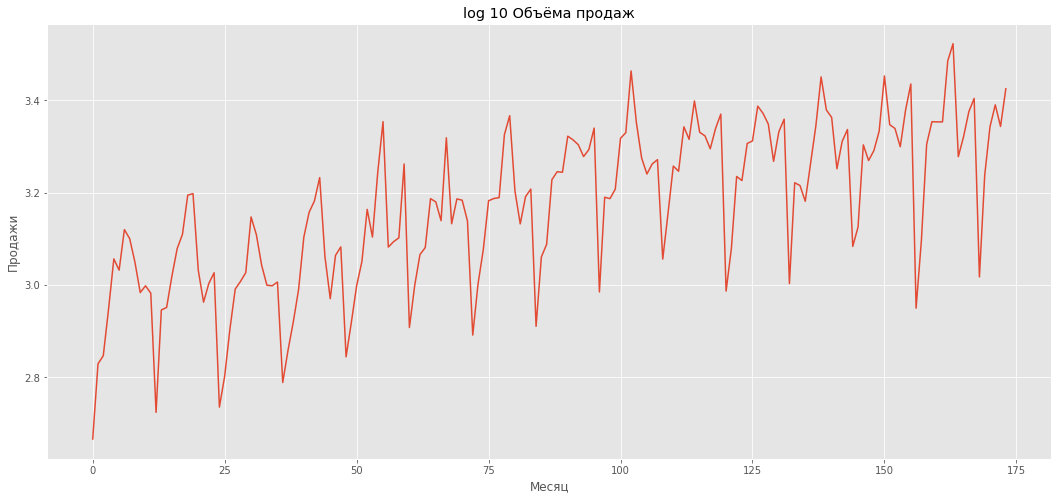

In [7]:
plt.figure(figsize=(18, 8))
np.log10(df1).plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'log 10 Объёма продаж')
plt.show()

<Figure size 1296x576 with 0 Axes>

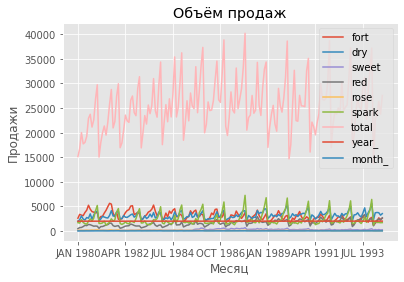

In [8]:
#  столбец дат
df2 = df[df.columns[9]]
#  В каких позициях на оси размещать даты? 
y_pos = np.arange(0, 175, 27)
plt.figure(figsize=(18, 8))
df.plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'Объём продаж')
# Добавляем даты на график
plt.xticks(y_pos, df2[y_pos])
plt.show()

Вывод: будем строить модель НЕлинейной регрессии для прогнозирования логарифма от объёма перевозок 
$$\log y_i = f(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- характеристики месяца,  $f(x_i)$ -- нелинейная функция харктеристик месяца, $\varepsilon_i$ -- случайный шум.

Создадим первый предиктор модели month_num -- порядковый номер пары (месяц, год).
Прологарифмируем временной ряд.
Добавим квадраты номеров наблюдений. Вдруг поможет. Тренд ведь нелинейный...

In [9]:
df = pd.read_csv('wine_Austral2.dat', sep='\t', header=0, usecols = ['red'])
df['month_num'] = range(1, len(df) + 1)
df['month_num_2'] = df['month_num']**2
df['log_y'] = np.log10(df['red'])
df.head()

,red,month_num,month_num_2,log_y
0,464,1,1,2.666518
1,675,2,4,2.829304
2,703,3,9,2.846955
3,887,4,16,2.947924
4,1139,5,25,3.056524


Предсказываем логарифм, поэтому исходный ряд не нужен

Даты не используем, но они были проигнорированы при импорте данных

In [10]:
df2 = df.drop(columns=["red"])

In [11]:
df2.head()

,month_num,month_num_2,log_y
0,1,1,2.666518
1,2,4,2.829304
2,3,9,2.846955
3,4,16,2.947924
4,5,25,3.056524


посчитаем за сколько месяцев собрали статистику

In [12]:
from math import ceil
months = ceil(174/12)
months

15

In [13]:
#Создадим новые переменные - индикаторы месяцев
df2["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]* months)[0:len(df)]
df2["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]* months)[0:len(df)]
df2["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]* months)[0:len(df)]
df2["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]* months)[0:len(df)]
df2["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]* months)[0:len(df)]
df2["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]* months)[0:len(df)]
df2["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]* months)[0:len(df)]
df2["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]* months)[0:len(df)]
df2["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]* months)[0:len(df)]
df2["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]* months)[0:len(df)]
df2["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]* months)[0:len(df)]
df2["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]* months)[0:len(df)]

In [14]:
#проверка
df2.head(15)

,month_num,month_num_2,log_y,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,1,2.666518,1,0,0,0,0,0,0,0,0,0,0,0
1,2,4,2.829304,0,1,0,0,0,0,0,0,0,0,0,0
2,3,9,2.846955,0,0,1,0,0,0,0,0,0,0,0,0
3,4,16,2.947924,0,0,0,1,0,0,0,0,0,0,0,0
4,5,25,3.056524,0,0,0,0,1,0,0,0,0,0,0,0
5,6,36,3.032216,0,0,0,0,0,1,0,0,0,0,0,0
6,7,49,3.119915,0,0,0,0,0,0,1,0,0,0,0,0
7,8,64,3.100371,0,0,0,0,0,0,0,1,0,0,0,0
8,9,81,3.049218,0,0,0,0,0,0,0,0,1,0,0,0
9,10,100,2.983626,0,0,0,0,0,0,0,0,0,1,0,0


Создаем матрицу предикторов.

На этот раз не надо убирать из нее столбец, соответствующий базовому месяцу

In [15]:
X = df2.drop(columns=["log_y"])
#  Создаем матрицу (столбец) откликов.
y = df2['log_y']

In [16]:
y.tail()

169    3.237544
170    3.342620
171    3.390051
172    3.343212
173    3.424882
Name: log_y, dtype: float64

Разделяем предикторы и отклики, тестовые и тренировочные выборки

In [17]:
X_train = df2.drop(columns=["log_y"]).iloc[:-8, :]
Y_train = df2['log_y'][:-8]
X_test = df2.drop(columns=["log_y"]).iloc[-8:, :]
Y_test = df2['log_y'][-8:]

строим модель

Подбираем параметры

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters = {  
    'n_estimators': [50, 70, 100, 150], # n_estimators - число деревьев в лесу
    'criterion': ['mse', 'mae'],        # criterion - функция для impurity
    'max_depth': [8,10,11]              # max_depth - число слоев или расщеплений
}

rf= GridSearchCV(RandomForestRegressor(random_state=239), parameters, cv=5, n_jobs=-1)
rf.fit(X_train, Y_train)

rf.best_params_

{'criterion': 'mae', 'max_depth': 11, 'n_estimators': 100}

Сравним подгонку и ряд разностей

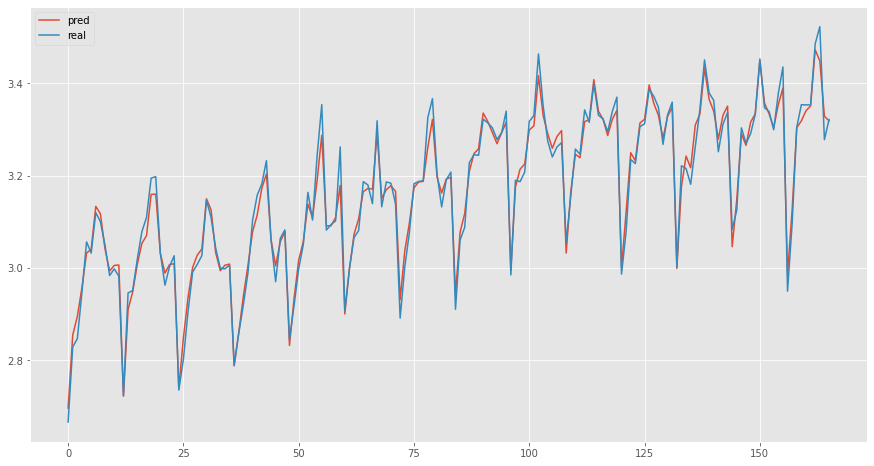

In [19]:
pred = pd.DataFrame({
    'pred': rf.predict(X_train),
    'real': Y_train})

pred.plot(figsize=(15,8))

довольно хорошее приближение

In [20]:
# критерий качества
print("SSE = ", sum((Y_train - rf.predict(X_train))**2))

SSE =  0.0961396756666368


От подгонки разностей переходим к подгонке ряда логарифмов

In [21]:
res = rf.predict(X_train)
a = [df['log_y'][0]]
for i in res:
    a.append(a[-1] + i)
print(a)

[2.6665179805548807, 5.36297954004063, 8.217890385063896, 11.113106232289823, 14.07091871949182, 17.10319510463636, 20.144286402121917, 23.277780605389886, 26.395152866928584, 29.43622068311421, 32.42979445657389, 35.43537987622938, 38.44188215270778, 41.16424690628237, 44.07413574666594, 47.022406414284035, 50.03045681641789, 53.08384602826489, 56.15383316788727, 59.31319285711293, 62.47310629642163, 65.50466785936635, 68.4936562316187, 71.50114488205367, 74.51050783755716, 77.25065811412557, 80.09915914597842, 83.03546723557697, 86.03668743457841, 89.06443088665658, 92.10573203598257, 95.25557723899635, 98.38136033946883, 101.41449944408046, 104.40861724608821, 107.41466493927884, 110.4231532598521, 113.21141789605785, 116.07166371529551, 119.01050726390667, 122.01606679191208, 125.09497184582405, 128.20965168021473, 131.38202693352983, 134.58572639993565, 137.647479109646, 140.65207389921937, 143.70861828043476, 146.7878142110279, 149.62006919894856, 152.55426696085175, 155.57154371

Прогноз для ряда логарифмов

In [22]:
df3 = pd.DataFrame()
df3['real'] = Y_test.values
df3['forecast'] = rf.predict(X_test)
df3['pred'] = np.nan
df3

,real,forecast,pred
0,3.375481,3.353391,NaN
1,3.403978,3.383597,NaN
2,3.017451,2.986296,NaN
3,3.237544,3.137122,NaN
4,3.342620,3.319612,NaN
5,3.390051,3.322773,NaN
6,3.343212,3.342985,NaN
7,3.424882,3.349439,NaN


матрица с подгонкой

In [23]:
pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
0,2.696462,2.666518,NaN
1,2.854911,2.829304,NaN
2,2.895216,2.846955,NaN
3,2.957812,2.947924,NaN
4,3.032276,3.056524,NaN


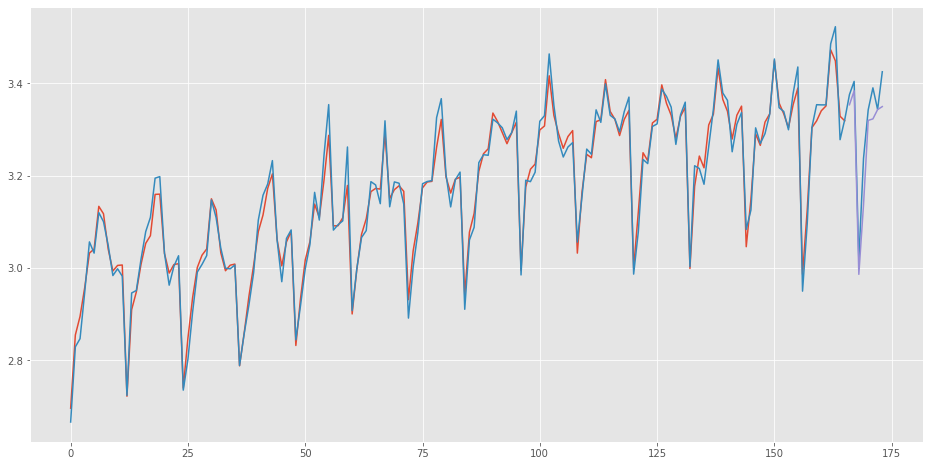

In [24]:
pred_1 = pd.concat(
    [pred, df3],
    sort=False
).reset_index(drop=True)

plt.figure(figsize=(16,8))
#  pred_1.plot()
plt.plot(pred_1)
plt.show()

Возвращаемся к исходному ряду

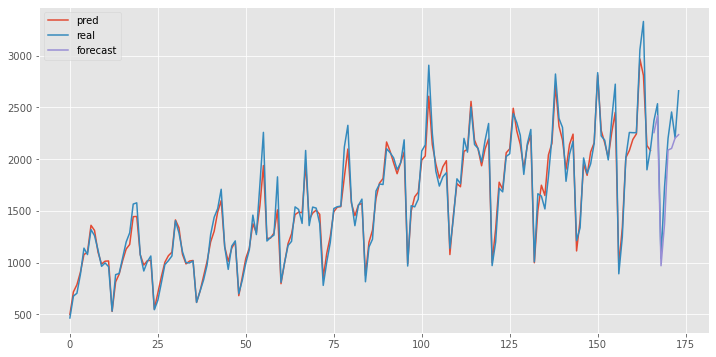

In [25]:
result = 10 ** pred_1
result.plot(figsize=(12,6))

Критерий качества - сумма квадратов ошибок

In [26]:
print("SSE = ", sum((Y_test - rf.predict(X_test)) ** 2))

SSE =  0.022705890773845286


## Вывод

По результатам работы был построен прогноз на 8 месяцев. Полученная модель, с подобранными параметрами имеет довольно точное приближение, что видно на графиках выше. Критерий качества весьма низок- количество ошибок стремится к 0.